
[Step 1] Loading Data...
  ✓ META        : 1256 rows, 13 features
  ✓ TESLA       : 1256 rows, 13 features
  ✓ NETFLIX     : 1256 rows, 13 features
  ✓ NVIDIA      : 1256 rows, 13 features
  ✓ PALANTIR    : 1256 rows, 13 features
  ✓ MICROSOFT   : 1256 rows, 13 features
  ✓ ALPHABET C  : 1256 rows, 13 features
  ✓ APPLE       : 1256 rows, 13 features
  ✓ BROADCOM    : 1256 rows, 13 features
  ✓ AMAZON      : 1256 rows, 13 features

✓ Loaded 10/10 stocks
✓ Benchmark loaded

✓ Final Shape: (1256, 152)
  Date Range: 2020-11-02 ~ 2025-10-31

[Step 2] Data Splitting...
  Train: 753 rows (2020-11-02 ~ 2023-10-30)
  Val:   311 rows
  Test:  312 rows (2024-08-06 ~ 2025-10-31)

[Step 3] Creating Tensors...
  Train: 688 sequences, Features: 13
  Val:   246 sequences
  Test:  247 sequences

[Phase 1] Training Advanced Predictor...
Epoch 10/80 | Train: 0.28543 | Val: 6.45067
Epoch 20/80 | Train: 0.15969 | Val: 7.65176
✓ Early stopping at epoch 20
✓ Best Val Loss: 6.45067

[Phase 2] Training PPO A

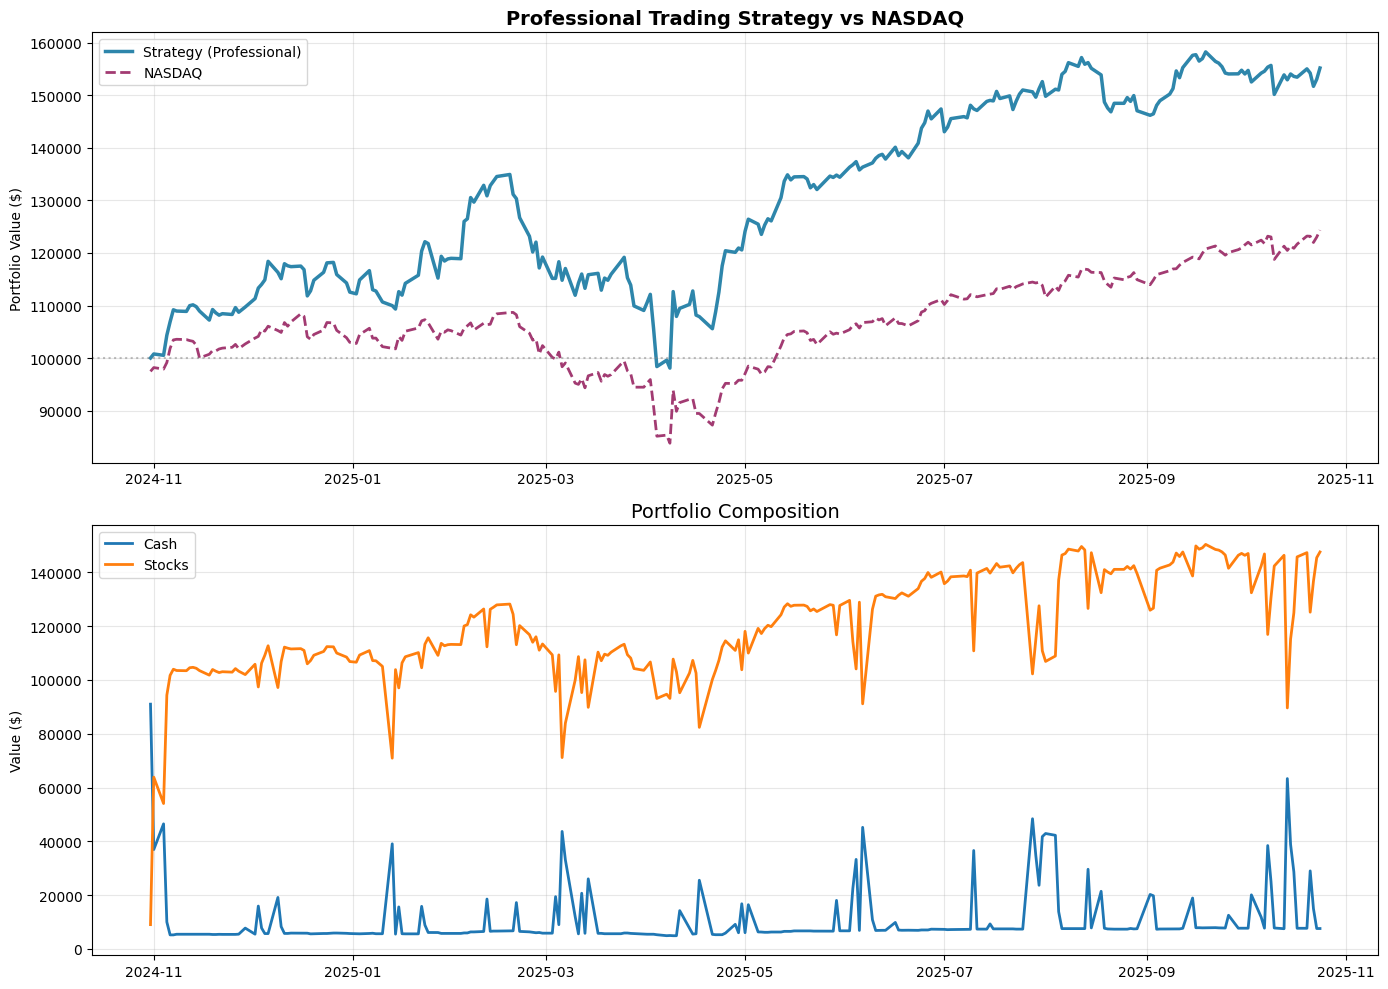

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

#config 클래스

class Config:
    STOCK_SYMBOLS = [
        'META', 'TESLA', 'NETFLIX', 'NVIDIA', 'PALANTIR',
        'MICROSOFT', 'ALPHABET C', 'APPLE', 'BROADCOM', 'AMAZON'
    ]
    LOOKBACK = 60
    PATCH_SIZE = 10
    STRIDE = 5
    HORIZON = 5

    BATCH_SIZE = 32
    EPOCHS_PREDICTOR = 80
    EPOCHS_PPO = 50
    LR = 0.00005
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    GAMMA = 0.99
    EPS_CLIP = 0.2
    K_EPOCHS = 5

    INITIAL_CAPITAL = 100000
    COMMISSION = 0.001
    SLIPPAGE = 0.0005
    MAX_POSITION_PCT = 0.18
    MIN_CASH_RATIO = 0.05      #

    TRAIN_RATIO = 0.6
    VAL_RATIO = 0.2
    TEST_RATIO = 0.2

    ENABLE_TRADING_LOG = True
    LOG_FILE = 'trading_log.xlsx'

config = Config()


#advanced technical 지표 클래스

class AdvancedTechnicalIndicators:
    @staticmethod   #함수의 인자로 넣을 것임.
    def add_all_indicators(df: pd.DataFrame, symbol: str) -> pd.DataFrame:
        close_col = f'{symbol}_Close'
        if len(df) < 60 or close_col not in df.columns:
            return df

        try:
            df[close_col] = pd.to_numeric(df[close_col], errors='coerce')
            df[close_col] = df[close_col].fillna(method='ffill').fillna(method='bfill')

            close = df[close_col]

            df[f'{symbol}_SMA_10'] = close.rolling(10).mean()
            df[f'{symbol}_SMA_20'] = close.rolling(20).mean()
            df[f'{symbol}_SMA_50'] = close.rolling(50).mean()
            df[f'{symbol}_EMA_12'] = close.ewm(span=12).mean()
            df[f'{symbol}_EMA_26'] = close.ewm(span=26).mean()

            # RSI
            delta = close.diff()
            gain = delta.where(delta > 0, 0).rolling(14).mean()
            loss = -delta.where(delta < 0, 0).rolling(14).mean()
            rs = gain / (loss + 1e-10)
            df[f'{symbol}_RSI'] = 100 - (100 / (1 + rs))

            # MACD
            df[f'{symbol}_MACD'] = df[f'{symbol}_EMA_12'] - df[f'{symbol}_EMA_26']
            df[f'{symbol}_MACD_Signal'] = df[f'{symbol}_MACD'].ewm(span=9).mean()

            df[f'{symbol}_Vol_20'] = close.pct_change().rolling(20).std()

            # Bollinger Bands
            sma_20 = df[f'{symbol}_SMA_20']
            std_20 = close.rolling(20).std()
            df[f'{symbol}_BB_Upper'] = sma_20 + 2 * std_20
            df[f'{symbol}_BB_Lower'] = sma_20 - 2 * std_20

            df[f'{symbol}_Price_Rank'] = close.rolling(50).apply(lambda x: (x[-1] - x.min()) / (x.max() - x.min() + 1e-10), raw=True)

        except Exception as e:
            print(f"  ⚠️ Indicator error for {symbol}: {str(e)}")
            return df

        return df.fillna(0)

# market regime 클래스 --> 시장의 상태를 반영하기 위한 클래스
class MarketRegimeDetector:
    @staticmethod
    def add_market_features(df: pd.DataFrame) -> pd.DataFrame:
        if 'NASDAQ' not in df.columns:
            return df

        try:
            nasdaq = df['NASDAQ']

            # 시장 추세
            df['Market_SMA_20'] = nasdaq.rolling(20).mean()
            df['Market_SMA_50'] = nasdaq.rolling(50).mean()
            df['Market_Trend'] = (df['Market_SMA_20'] - df['Market_SMA_50']) / (df['Market_SMA_50'] + 1e-10)

            # 시장 변동성
            df['Market_Volatility'] = nasdaq.pct_change().rolling(20).std()

            # 시장 모멘텀
            df['Market_Returns'] = nasdaq.pct_change()
            df['Market_Returns_10'] = nasdaq.pct_change(10)

            # 시장 상태 (0: 하락, 1: 중립, 2: 상승)
            df['Market_Regime'] = 1  # 기본값
            df.loc[df['Market_Trend'] > 0.02, 'Market_Regime'] = 2  # 상승
            df.loc[df['Market_Trend'] < -0.02, 'Market_Regime'] = 0  # 하락

        except Exception as e:
            print(f"  ⚠️ Market regime error: {e}")

        return df.fillna(method='bfill').fillna(0)


# 데이터 로드하는 클래스
def load_data_pipeline():
    print("\n[Step 1] Loading Data...")
    #colab에 올려둔 macro data 불러오기
    macro_path = '/content/macro_economic_data.csv'
    if os.path.exists(macro_path):
        macro_df = pd.read_csv(macro_path)
        macro_df.columns = macro_df.columns.str.strip()
        if 'Date' not in macro_df.columns:
            macro_df.rename(columns={macro_df.columns[0]: 'Date'}, inplace=True)
        macro_df['Date'] = pd.to_datetime(macro_df['Date'])
        if 'NASDAQ' in macro_df.columns:
            macro_df = macro_df.drop(columns=['NASDAQ'])
    else:
        dates = pd.date_range('2020-01-01', periods=1500)
        macro_df = pd.DataFrame({'Date': dates, 'VIX': 20})

    combined_df = macro_df.copy()
    stock_feats_dict = {}

    loaded_count = 0
    for symbol in config.STOCK_SYMBOLS:
        fname = f"/content/{symbol} 5년치.csv"

        if os.path.exists(fname):
            df = pd.read_csv(fname)
            df.columns = df.columns.str.strip()

            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
            else:
                df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
                df['Date'] = pd.to_datetime(df['Date'])

            for col in df.columns:
                if df[col].dtype == 'object' and col != 'Date':
                    try:
                        df[col] = df[col].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
                    except: pass

            close_col_idx = 1
            for idx, col_name in enumerate(df.columns):
                if 'Close' in col_name or 'Last' in col_name:
                    close_col_idx = idx
                    break

            df_subset = df.iloc[:, [0, close_col_idx]].copy()
            df_subset.columns = ['Date', f'{symbol}_Close']

            # ★ 고급 지표 적용
            df_subset = AdvancedTechnicalIndicators.add_all_indicators(df_subset, symbol)

            combined_df = pd.merge(combined_df, df_subset, on='Date', how='inner')

            cols = [c for c in df_subset.columns if c != 'Date']
            stock_feats_dict[symbol] = cols
            loaded_count += 1
            print(f"  ✓ {symbol:12s}: {len(df)} rows, {len(cols)} features")

    if loaded_count == 0:
        raise ValueError("❌ No stock data loaded!")

    print(f"\n✓ Loaded {loaded_count}/{len(config.STOCK_SYMBOLS)} stocks")

    combined_df = combined_df.sort_values('Date').reset_index(drop=True)


    # NASDAQ 벤치마크로 활용(qqq)
    qqq_path = "/content/NASDAQ 5년치.csv"
    if os.path.exists(qqq_path):
        qqq_df = pd.read_csv(qqq_path)
        qqq_df.columns = qqq_df.columns.str.strip()

        if 'Date' in qqq_df.columns:
            qqq_df['Date'] = pd.to_datetime(qqq_df['Date'])
        else:
            qqq_df.rename(columns={qqq_df.columns[0]: 'Date'}, inplace=True)
            qqq_df['Date'] = pd.to_datetime(qqq_df['Date'])

        nasdaq_col = None
        for col in qqq_df.columns:
            if 'Close' in col or 'Last' in col:
                nasdaq_col = col
                break

        if nasdaq_col:
            if qqq_df[nasdaq_col].dtype == 'object':
                qqq_df[nasdaq_col] = qqq_df[nasdaq_col].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

            qqq_df = qqq_df.rename(columns={nasdaq_col: 'NASDAQ'})
            qqq_subset = qqq_df[['Date', 'NASDAQ']].copy()
            combined_df = pd.merge(combined_df, qqq_subset, on='Date', how='left')
            print(f"✓ Benchmark loaded")
        else:
            combined_df['NASDAQ'] = 100.0
    else:
        combined_df['NASDAQ'] = 100.0

    combined_df['NASDAQ'] = combined_df['NASDAQ'].fillna(method='ffill').fillna(100.0)

    # 시장 상태 특성 추가
    combined_df = MarketRegimeDetector.add_market_features(combined_df)

    print(f"\n✓ Final Shape: {combined_df.shape}")
    print(f"  Date Range: {combined_df['Date'].min().date()} ~ {combined_df['Date'].max().date()}")

    return combined_df, stock_feats_dict



#주가 예측 모델 클래스(patchtst_GNN 활용)
class PatchTST_GNN_Model(nn.Module):
    def __init__(self, n_stocks, n_features_per_stock, config):
        super().__init__()
        self.n_stocks = n_stocks
        self.n_features = n_features_per_stock
        self.patch_size = config.PATCH_SIZE
        self.stride = config.STRIDE
        self.d_model = 128
        self.num_patches = (config.LOOKBACK - self.patch_size) // self.stride + 1

        self.input_projection = nn.Linear(self.patch_size * self.n_features, self.d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=4, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.flatten_head = nn.Linear(self.num_patches * self.d_model, self.d_model)

        self.gnn_proj = nn.Linear(self.d_model, self.d_model)
        self.adj = nn.Parameter(torch.randn(n_stocks, n_stocks))
        self.predictor = nn.Linear(self.d_model, config.HORIZON)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3)
        B, N, L, n_feats = x.shape

        x_flat = x.reshape(B * N, L, n_feats)
        patches = x_flat.unfold(1, self.patch_size, self.stride)
        patches = patches.permute(0, 1, 3, 2).reshape(B * N, self.num_patches, -1)

        emb = self.input_projection(patches)
        tf_out = self.transformer(emb)
        tf_out = tf_out.reshape(B * N, -1)
        stock_emb = self.flatten_head(tf_out)
        stock_emb = stock_emb.view(B, N, self.d_model)

        adj_norm = torch.sigmoid(self.adj)
        gnn_out = torch.einsum('nm, bmd -> bnd', adj_norm, stock_emb)
        gnn_out = F.relu(self.gnn_proj(gnn_out))

        final_emb = stock_emb + gnn_out
        out = self.predictor(final_emb)
        return out.permute(0, 2, 1)


#PPO 강화학습 ai 트레이더 이용

class PPOAgent(nn.Module):
    def __init__(self, state_dim, n_stocks, lr=0.0003, gamma=0.99, eps_clip=0.2, k_epochs=5):
        super(PPOAgent, self).__init__()
        self.n_stocks = n_stocks
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, n_stocks * 3)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.MseLoss = nn.MSELoss()
        self.data = []

    def put_data(self, transition):
        self.data.append(transition)

    def get_action(self, state):
        logits = self.actor(state).view(1, self.n_stocks, 3)
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.detach(), log_prob.detach(), probs.detach()

    def update(self):    # ppo에 저장된 데이터를 통해서 학습-->업데이트시킴
        if len(self.data) == 0: return
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append(prob_a)
            done_lst.append([done])

        s = torch.stack(s_lst).squeeze(1).to(config.DEVICE)
        a = torch.stack(a_lst).squeeze(1).to(config.DEVICE)
        r = torch.tensor(r_lst, dtype=torch.float).to(config.DEVICE)
        s_prime = torch.stack(s_prime_lst).squeeze(1).to(config.DEVICE)
        done_mask = torch.tensor(done_lst, dtype=torch.float).to(config.DEVICE)
        prob_a = torch.stack(prob_a_lst).squeeze(1).to(config.DEVICE)

        with torch.no_grad():
            targets = r + self.gamma * self.critic(s_prime) * (1 - done_mask)

        for _ in range(self.k_epochs):
            logits = self.actor(s).view(-1, self.n_stocks, 3)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)

            log_prob = dist.log_prob(a)
            entropy = dist.entropy().mean()

            ratio = torch.exp(log_prob - prob_a)
            if ratio.dim() > 1: ratio = ratio.mean(dim=1, keepdim=True)

            values = self.critic(s)
            advantage = targets - values

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(values, targets) - 0.01 * entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        self.data = []


#매매일지 작성 클래스

class TradingLogger:
    def __init__(self, stock_symbols, initial_capital):
        self.stock_symbols = stock_symbols
        self.n_stocks = len(stock_symbols)
        self.initial_capital = initial_capital

        # 일일 기록
        self.daily_log = []

        # 거래 기록
        self.trades = []

        # 포트폴리오 변화
        self.portfolio_history = []

    def log_daily(self, date, cash, holdings, prices, actions, predictions, portfolio_value, benchmark_value):

        # 주식 가치 계산
        stock_values = holdings * prices
        total_stock_value = np.sum(stock_values)

        # 각 종목별 비중
        weights = stock_values / portfolio_value if portfolio_value > 0 else np.zeros(self.n_stocks)

        # 일일 수익률
        if len(self.daily_log) > 0:
            prev_value = self.daily_log[-1]['Portfolio_Value']
            daily_return = (portfolio_value - prev_value) / prev_value * 100
        else:
            daily_return = 0.0

        daily_record = {
            'Date': date,
            'Portfolio_Value': portfolio_value,
            'Cash': cash,
            'Stock_Value': total_stock_value,
            'Cash_Ratio': cash / portfolio_value if portfolio_value > 0 else 0,
            'Daily_Return': daily_return,
            'Benchmark_Value': benchmark_value,
        }

        # 각 종목별 상세
        for i, symbol in enumerate(self.stock_symbols):
            daily_record[f'{symbol}_Shares'] = holdings[i]
            daily_record[f'{symbol}_Price'] = prices[i]
            daily_record[f'{symbol}_Value'] = stock_values[i]
            daily_record[f'{symbol}_Weight'] = weights[i] * 100
            daily_record[f'{symbol}_Action'] = ['HOLD', 'BUY', 'SELL'][actions[i]]
            daily_record[f'{symbol}_Prediction'] = predictions[i]

        self.daily_log.append(daily_record)

    def log_trade(self, date, symbol, action, shares, price, value, reason):
        """개별 거래 기록"""
        trade_record = {
            'Date': date,
            'Symbol': symbol,
            'Action': action,
            'Shares': shares,
            'Price': price,
            'Value': value,
            'Reason': reason
        }
        self.trades.append(trade_record)

    def save_to_excel(self, filename='trading_log.xlsx'):
        """엑셀로 저장"""
        try:
            with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                # 1. 일일 요약
                if self.daily_log:
                    df_daily = pd.DataFrame(self.daily_log)
                    df_daily.to_excel(writer, sheet_name='Daily_Summary', index=False)

                # 2. 거래 내역
                if self.trades:
                    df_trades = pd.DataFrame(self.trades)
                    df_trades.to_excel(writer, sheet_name='Trades', index=False)

                # 3. 포트폴리오 구성 (마지막 날)
                if self.daily_log:
                    last_day = self.daily_log[-1]
                    portfolio_data = []
                    for symbol in self.stock_symbols:
                        if f'{symbol}_Shares' in last_day:
                            portfolio_data.append({
                                'Symbol': symbol,
                                'Shares': last_day[f'{symbol}_Shares'],
                                'Price': last_day[f'{symbol}_Price'],
                                'Value': last_day[f'{symbol}_Value'],
                                'Weight': last_day[f'{symbol}_Weight']
                            })
                    df_portfolio = pd.DataFrame(portfolio_data)
                    df_portfolio.to_excel(writer, sheet_name='Final_Portfolio', index=False)

            print(f"\n✅ Trading log saved: {filename}")
        except Exception as e:
            print(f"\n⚠️ Failed to save trading log: {e}")

    def print_summary(self):
        if not self.daily_log:
            return

        print("\n" + "="*80)
        print("📊 TRADING LOG SUMMARY")
        print("="*80)

        df = pd.DataFrame(self.daily_log)

        # 전체 수익률
        initial = self.initial_capital
        final = df['Portfolio_Value'].iloc[-1]
        total_return = (final - initial) / initial * 100

        print(f"\n기간: {df['Date'].iloc[0]} ~ {df['Date'].iloc[-1]}")
        print(f"거래일수: {len(df)}일")
        print(f"\n초기 자본: ${initial:,.2f}")
        print(f"최종 자산: ${final:,.2f}")
        print(f"수익률: {total_return:+.2f}%")

        # 거래 통계
        if self.trades:
            print(f"\n총 거래 횟수: {len(self.trades)}건")
            df_trades = pd.DataFrame(self.trades)
            buy_count = len(df_trades[df_trades['Action'] == 'BUY'])
            sell_count = len(df_trades[df_trades['Action'] == 'SELL'])
            print(f"  매수: {buy_count}건")
            print(f"  매도: {sell_count}건")

        # 최종 포트폴리오
        print(f"\n최종 포트폴리오 구성:")
        print(f"  현금: ${df['Cash'].iloc[-1]:,.2f} ({df['Cash_Ratio'].iloc[-1]*100:.1f}%)")
        print(f"  주식: ${df['Stock_Value'].iloc[-1]:,.2f}")

        print(f"\n주요 보유 종목 (비중 > 5%):")
        last_day = self.daily_log[-1]
        holdings_info = []
        for symbol in self.stock_symbols:
            weight = last_day.get(f'{symbol}_Weight', 0)
            if weight > 5:
                value = last_day.get(f'{symbol}_Value', 0)
                shares = last_day.get(f'{symbol}_Shares', 0)
                holdings_info.append((symbol, weight, value, shares))

        holdings_info.sort(key=lambda x: x[1], reverse=True)
        for symbol, weight, value, shares in holdings_info:
            print(f"  {symbol:12s}: {weight:5.1f}% (${value:>10,.2f}, {shares:>8,.2f} shares)")

        print("="*80)


# 매수, 매도 실행하고 보장을 주는 클래스

class ProfessionalTradingEnv:
    def __init__(self, prices, predictions, dates, benchmark_prices, config, stock_symbols, logger=None):
        self.prices = prices
        self.predictions = predictions
        self.dates = dates
        self.benchmark = benchmark_prices
        self.config = config
        self.stock_symbols = stock_symbols
        self.n_stocks = prices.shape[1]
        self.logger = logger
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.config.INITIAL_CAPITAL
        self.holdings = np.zeros(self.n_stocks)
        self.history = []
        return self._get_state()

    def _get_state(self):
        curr_price = self.prices[self.t]
        port_val = self.cash + np.sum(self.holdings * curr_price)

        cash_ratio = self.cash / (port_val + 1e-8)
        holdings_ratio = (self.holdings * curr_price) / (port_val + 1e-8)

        if self.t < len(self.predictions):
            pred_return = (self.predictions[self.t, 0, :] - curr_price) / (curr_price + 1e-8)
        else:
            pred_return = np.zeros(self.n_stocks)

        state = np.concatenate([[cash_ratio], holdings_ratio, pred_return])
        return torch.FloatTensor(state), pred_return

    def step(self, actions, probs=None):
        curr_price = self.prices[self.t]
        date = self.dates[self.t]
        prev_val = self.cash + np.sum(self.holdings * curr_price)

        state, pred_returns = self._get_state()

        # 매도 먼저
        for i, action in enumerate(actions):
            if action == 2 and self.holdings[i] > 0:
                price = curr_price[i] * (1 - self.config.SLIPPAGE)
                revenue = self.holdings[i] * price
                shares_sold = self.holdings[i]

                self.cash += revenue * (1 - self.config.COMMISSION)
                self.holdings[i] = 0

                # 매도 사유
                reason = f"Negative prediction: {pred_returns[i]*100:.2f}%"
                if self.logger:
                    self.logger.log_trade(date, self.stock_symbols[i], 'SELL',
                                        shares_sold, price, revenue, reason)

        # 매수
        for i, action in enumerate(actions):
            if action == 1:
                price = curr_price[i] * (1 + self.config.SLIPPAGE)

                current_position_value = self.holdings[i] * curr_price[i]
                max_position_value = prev_val * self.config.MAX_POSITION_PCT
                available_to_buy = max_position_value - current_position_value

                # 최소 현금 유지
                min_cash = prev_val * self.config.MIN_CASH_RATIO
                available_cash = max(0, self.cash - min_cash)

                if available_to_buy > 0 and available_cash > 0:
                    target_amt = (prev_val * 0.9) / self.n_stocks
                    invest_amt = min(target_amt, available_to_buy, available_cash)

                    cost = invest_amt * (1 + self.config.COMMISSION)

                    if self.cash >= cost and invest_amt > 0:
                        shares = invest_amt / price
                        self.cash -= cost
                        self.holdings[i] += shares

                        # 매수 사유
                        reason = f"Positive prediction: {pred_returns[i]*100:.2f}%"
                        if probs is not None:
                            buy_prob = probs[0, i, 1].item() * 100
                            reason += f", Confidence: {buy_prob:.1f}%"

                        if self.logger:
                            self.logger.log_trade(date, self.stock_symbols[i], 'BUY',
                                                shares, price, invest_amt, reason)

        self.t += 1
        done = self.t >= len(self.prices) - 1

        next_price = self.prices[self.t]
        curr_val = self.cash + np.sum(self.holdings * next_price)

        if len(self.benchmark) > self.t:
            bench_val = (self.benchmark[self.t] / self.benchmark[0]) * self.config.INITIAL_CAPITAL
        else:
            bench_val = self.config.INITIAL_CAPITAL

        # 매매일지 기록
        if self.logger:
            self.logger.log_daily(
                date=self.dates[self.t],
                cash=self.cash,
                holdings=self.holdings.copy(),
                prices=next_price,
                actions=actions,
                predictions=pred_returns,
                portfolio_value=curr_val,
                benchmark_value=bench_val
            )

        self.history.append({
            'Date': self.dates[self.t],
            'Strategy': curr_val,
            'Benchmark': bench_val,
            'Cash': self.cash,
            'Stock_Value': np.sum(self.holdings * next_price)
        })

        reward = (curr_val - prev_val) / (prev_val + 1e-8)

        next_state, _ = self._get_state()
        return next_state, reward, done


# 데이터셋 클래스
def create_dataset(df_segment, stock_feats, config):
    X_list, y_list = [], []
    if len(df_segment) <= config.LOOKBACK + config.HORIZON:
        return np.array([]), np.array([])

    for i in range(len(df_segment) - config.LOOKBACK - config.HORIZON):
        window = []
        for sym in config.STOCK_SYMBOLS:
            if sym not in stock_feats: continue
            feats = stock_feats[sym]
            window.append(df_segment.iloc[i : i+config.LOOKBACK][feats].values)

        if len(window) == len([s for s in config.STOCK_SYMBOLS if s in stock_feats]):
            X_list.append(np.stack(window, axis=1))

            targets = []
            for sym in config.STOCK_SYMBOLS:
                if sym not in stock_feats: continue
                targets.append(df_segment.iloc[i+config.LOOKBACK : i+config.LOOKBACK+config.HORIZON][f'{sym}_Close'].values)
            y_list.append(np.stack(targets, axis=1))

    return np.array(X_list), np.array(y_list)







### MAIN

def main():
    df, stock_feats = load_data_pipeline()

    if len(df) == 0:
        print("\n❌ Error: No data loaded.")
        return

    if 'NASDAQ' not in df.columns:
        print("\n❌ Error: NASDAQ column not found!")
        return

    n = len(df)
    train_end = int(n * config.TRAIN_RATIO)
    val_end = int(n * (config.TRAIN_RATIO + config.VAL_RATIO))

    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end - config.LOOKBACK:val_end].copy()
    test_df = df.iloc[val_end - config.LOOKBACK:].copy()

    print(f"\n[Step 2] Data Splitting...")
    print(f"  Train: {len(train_df)} rows ({train_df['Date'].min().date()} ~ {train_df['Date'].max().date()})")
    print(f"  Val:   {len(val_df)} rows")
    print(f"  Test:  {len(test_df)} rows ({test_df['Date'].min().date()} ~ {test_df['Date'].max().date()})")

    numeric_cols = [c for c in df.columns if c not in ['Date', 'NASDAQ']]
    scaler = StandardScaler()
    scaler.fit(train_df[numeric_cols])

    train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    print(f"\n[Step 3] Creating Tensors...")
    X_train, y_train = create_dataset(train_df, stock_feats, config)
    X_val, y_val = create_dataset(val_df, stock_feats, config)
    X_test, y_test = create_dataset(test_df, stock_feats, config)

    if len(X_train) == 0 or len(X_test) == 0:
        print("❌ Error: Not enough data.")
        return

    X_train_t = torch.FloatTensor(X_train).to(config.DEVICE)
    y_train_t = torch.FloatTensor(y_train).to(config.DEVICE)
    X_val_t = torch.FloatTensor(X_val).to(config.DEVICE)
    y_val_t = torch.FloatTensor(y_val).to(config.DEVICE)
    X_test_t = torch.FloatTensor(X_test).to(config.DEVICE)

    print(f"  Train: {X_train.shape[0]} sequences, Features: {X_train.shape[-1]}")
    print(f"  Val:   {X_val.shape[0]} sequences")
    print(f"  Test:  {X_test.shape[0]} sequences")

    # Phase 1: Predictor
    print("\n" + "="*80)
    print("[Phase 1] Training Advanced Predictor...")
    print("="*80)

    n_features = X_train.shape[-1]
    n_stocks = len([s for s in config.STOCK_SYMBOLS if s in stock_feats])

    model = PatchTST_GNN_Model(n_stocks, n_features, config).to(config.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config.LR)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(config.EPOCHS_PREDICTOR):
        model.train()
        pred = model(X_train_t)
        train_loss = criterion(pred, y_train_t)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1:2d}/{config.EPOCHS_PREDICTOR} | Train: {train_loss.item():.5f} | Val: {val_loss.item():.5f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"✓ Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    print(f"✓ Best Val Loss: {best_val_loss:.5f}")

    # Phase 2: PPO
    print("\n" + "="*80)
    print("[Phase 2] Training PPO Agent...")
    print("="*80)

    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_t).cpu().numpy()

    train_raw = df.iloc[:train_end].reset_index(drop=True)
    sim_start = config.LOOKBACK
    sim_len = len(train_preds)

    train_prices = []
    for sym in config.STOCK_SYMBOLS:
        if sym not in stock_feats: continue
        train_prices.append(train_raw.iloc[sim_start:sim_start+sim_len][f'{sym}_Close'].values)
    train_prices = np.stack(train_prices, axis=1)

    train_dates = train_raw.iloc[sim_start:sim_start+sim_len]['Date'].values
    train_bench = train_raw.iloc[sim_start:sim_start+sim_len]['NASDAQ'].values

    env_train = ProfessionalTradingEnv(train_prices, train_preds, train_dates, train_bench,
                                      config, config.STOCK_SYMBOLS, logger=None)
    state_dim = 1 + n_stocks + n_stocks
    agent = PPOAgent(state_dim, n_stocks).to(config.DEVICE)

    for ep in range(config.EPOCHS_PPO):
        state, _ = env_train.reset()
        state = state.to(config.DEVICE)
        done = False
        score = 0
        while not done:
            action, log_prob, probs = agent.get_action(state.unsqueeze(0))
            action_val = action.cpu().numpy()[0]
            next_state, reward, done = env_train.step(action_val)
            next_state = next_state.to(config.DEVICE)
            agent.put_data((state, action, reward, next_state, log_prob, done))
            state = next_state
            score += reward
        agent.update()
        if (ep+1) % 10 == 0:
            print(f"Episode {ep+1:2d}/{config.EPOCHS_PPO} | Score: {score:.4f}")

    print("\n" + "="*80)
    print("[Phase 3] Backtesting with Trading Log...")
    print("="*80)

    with torch.no_grad():
        test_preds = model(X_test_t).cpu().numpy()

    test_raw = df.iloc[val_end - config.LOOKBACK:].reset_index(drop=True)
    sim_start = config.LOOKBACK
    sim_len = len(test_preds)

    test_prices = []
    for sym in config.STOCK_SYMBOLS:
        if sym not in stock_feats: continue
        test_prices.append(test_raw.iloc[sim_start:sim_start+sim_len][f'{sym}_Close'].values)
    test_prices = np.stack(test_prices, axis=1)

    test_dates = test_raw.iloc[sim_start:sim_start+sim_len]['Date'].values
    test_bench = test_raw.iloc[sim_start:sim_start+sim_len]['NASDAQ'].values

    logger = TradingLogger(config.STOCK_SYMBOLS, config.INITIAL_CAPITAL) if config.ENABLE_TRADING_LOG else None

    env_test = ProfessionalTradingEnv(test_prices, test_preds, test_dates, test_bench,
                                     config, config.STOCK_SYMBOLS, logger=logger)

    state, _ = env_test.reset()
    state = state.to(config.DEVICE)
    done = False
    while not done:
        with torch.no_grad():
            action, _, probs = agent.get_action(state.unsqueeze(0))
        next_state, reward, done = env_test.step(action.cpu().numpy()[0], probs)
        state = next_state.to(config.DEVICE)

    res_df = pd.DataFrame(env_test.history)

    if not res_df.empty:
        strat_ret = (res_df['Strategy'].iloc[-1] / res_df['Strategy'].iloc[0]) - 1
        bench_ret = (res_df['Benchmark'].iloc[-1] / res_df['Benchmark'].iloc[0]) - 1
        alpha = strat_ret - bench_ret

        returns = res_df['Strategy'].pct_change().dropna()
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if len(returns) > 0 else 0

        cumulative = res_df['Strategy'].values
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        max_dd = np.min(drawdown) * 100

        print("\n" + "="*80)
        print("📊 FINAL RESULTS (Professional Edition)")
        print("="*80)
        print(f"Test Period: {res_df['Date'].iloc[0]} ~ {res_df['Date'].iloc[-1]}")
        print(f"Duration: {len(res_df)} trading days\n")

        print(f"Initial Capital:  ${config.INITIAL_CAPITAL:>12,.2f}")
        print(f"Final Strategy:   ${res_df['Strategy'].iloc[-1]:>12,.2f}")
        print(f"Final Benchmark:  ${res_df['Benchmark'].iloc[-1]:>12,.2f}\n")

        print("-" * 80)
        print(f"Strategy Return:   {strat_ret*100:>9.2f}%")
        print(f"Benchmark (NASDAQ):{bench_ret*100:>9.2f}%")
        print(f"Alpha:             {alpha*100:>9.2f}%p")
        print("-" * 80)
        print(f"Sharpe Ratio:      {sharpe:>9.2f}")
        print(f"Max Drawdown:      {max_dd:>9.2f}%")
        print("="*80)

        if logger:
            logger.print_summary()
            logger.save_to_excel(config.LOG_FILE)

        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        axes[0].plot(res_df['Date'], res_df['Strategy'], label='Strategy (Professional)', linewidth=2.5, color='#2E86AB')
        axes[0].plot(res_df['Date'], res_df['Benchmark'], label='NASDAQ', linewidth=2, color='#A23B72', linestyle='--')
        axes[0].axhline(y=config.INITIAL_CAPITAL, color='gray', linestyle=':', alpha=0.5)
        axes[0].set_title('Professional Trading Strategy vs NASDAQ', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Portfolio Value ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(res_df['Date'], res_df['Cash'], label='Cash', linewidth=2)
        axes[1].plot(res_df['Date'], res_df['Stock_Value'], label='Stocks', linewidth=2)
        axes[1].set_title('Portfolio Composition', fontsize=14)
        axes[1].set_ylabel('Value ($)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("\n❌ Error: No history.")

if __name__ == "__main__":
    main()